`Deep Learning By PhD Scholar`
## Problems in the FER 2013 dataset
- **Imbalance**: 7214 pictures of happy but only 436 of disgust. Neural netowrk will be biased towards 'Happy'
Soln: **Data Augmentation** (Create more images by rotation, scale etc)
- **Intra-class Variation**: All images do not belong to same class (eg. FER contains faces, paintings, cartoons etc)
Soln: Avoid Overfitting
- **Occlusion**: Parts covered with hand
- **Contrast Variation**: Images too black and white
- **Eyeglasses**
- **Outliers**

## Methodology
FER 2013 dataset (48x48) --bilinear interpolation--> 224x224 --> **Transfer Learning** (MobileNetv2, GoogleNet, ResNet, AlexNet etc [trained for 224x224 images to classify into 1000 classes])

In [1]:
# ! pip install -q kaggle

# from google.colab import files
# files.upload()

In [2]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/


In [3]:
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [4]:
# ! kaggle competitions download -c 'fer2013'

In [5]:
# Downloading the dataset to colab environment, './fer2013'

!pip install opendatasets
!pip install pandas


import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/msambare/fer2013", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zengarv
Your Kaggle Key: ··········


100%|██████████| 60.3M/60.3M [00:00<00:00, 148MB/s]


In [6]:
import os

In [7]:
# Renaming all the folders to integers

# emotional_indices = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}

# for folder in os.listdir('./fer2013/train'):
#   os.rename(f"./fer2013/train/{folder}", f"./fer2013/train/{emotional_indices[folder]}")
#   os.rename(f"./fer2013/test/{folder}", f"./fer2013/test/{emotional_indices[folder]}")

In [8]:
# Renaming the files

# for folder in os.listdir('./fer2013/train'):
#   for i, img in enumerate(os.listdir(f"./fer2013/train/{folder}")):
#     os.rename(f"./fer2013/train/{folder}/{img}", f"./fer2013/train/{folder}/{i}.jpg")
#   for j, img in enumerate(os.listdir(f"./fer2013/test/{folder}")):
#     os.rename(f"./fer2013/test/{folder}/{img}", f"./fer2013/test/{folder}/{j}.jpg")

In [9]:
import tensorflow as tf
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [10]:
img_array = cv2.imread('./fer2013/train/angry/Training_10118481.jpg')
img_array.shape  # (48, 48, 3), rgb image

(48, 48, 3)

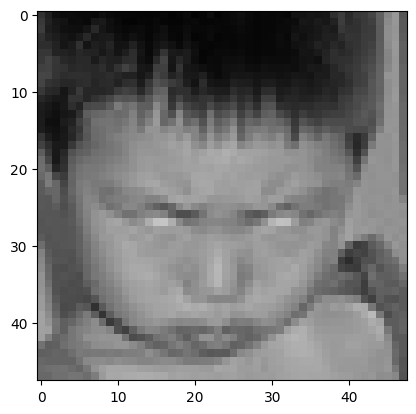

In [11]:
plt.imshow(img_array)  # Image is blurry

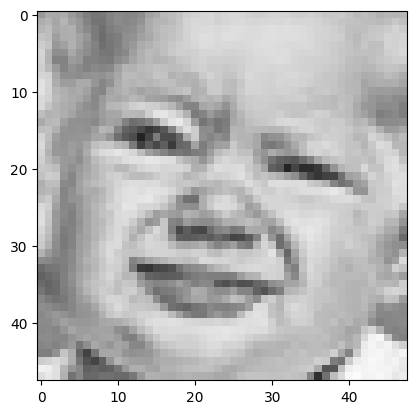

In [12]:
data_dir = "./fer2013/train/"
# classes = ["0", "1", "2", "3", "4", "5", "6"]
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Loop through all the images in the train folder
for category in classes:
    path = os.path.join(data_dir, category)

    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        # back2rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break

    break

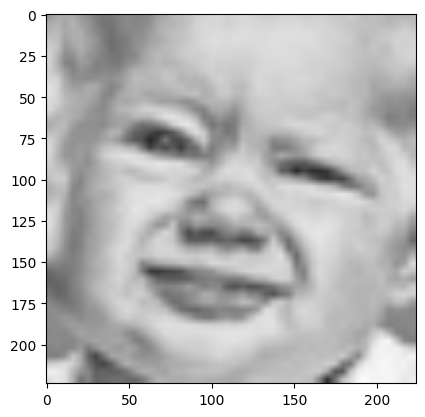

In [13]:
# Change the size of the images (Upsscale them to 224x224)
img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
# new_array has shape (224, 224, 3)

In [14]:
from tqdm.notebook import tqdm

# Read all the images and convert them to array

# training_data = []   # Images are upscaled 'in place'

def create_training_data():
    for class_num, category in enumerate(classes):
        path = os.path.join(data_dir, category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                # training_data.append([new_array, class_num])            # Append as (img_array, label)
                cv2.imwrite(os.path.join(path, img), new_array)           # Images are made of size 224x224, in place
            except Exception as e:
                print(f"Error in processing {os.path.join(path, img)}")

In [15]:
create_training_data()

  0%|          | 0/3995 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/4097 [00:00<?, ?it/s]

  0%|          | 0/7215 [00:00<?, ?it/s]

  0%|          | 0/4965 [00:00<?, ?it/s]

  0%|          | 0/4830 [00:00<?, ?it/s]

  0%|          | 0/3171 [00:00<?, ?it/s]

In [31]:
seed_train_validation = 123 # Must be same for train_ds and val_ds
shuffle_value = True

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory ='./fer2013/train',
  image_size = (224, 224),
  subset = "training",
  seed = seed_train_validation,
  color_mode = 'rgb',
  shuffle = shuffle_value,
  validation_split = 0.2,
  batch_size=128)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory ='./fer2013/test',
  image_size = (224, 224),
  subset = "validation",
  seed = seed_train_validation,
  validation_split = 0.2,
  color_mode = 'rgb',
  shuffle = shuffle_value)

# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)

# image_data_train = image_generator.flow_from_directory(str('./fer2013/train'),subset='training')
# image_data_val = image_generator.flow_from_directory(str('./fer2013/test'),subset='validation')


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 7178 files belonging to 7 classes.
Using 1435 files for validation.


In [32]:
# Creating the model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [33]:
# model = tf.keras.applications.MobileNetV2()  # TODO: Try out v3
# model.summary()

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [34]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 7, 7, 1280)


In [35]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [36]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [37]:
prediction_layer = tf.keras.layers.Dense(7)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 7)


In [38]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 2,266,951
Trainable params: 8,967
Non-trainab

In [39]:
# base_input = model.layers[0].input
# base_output = model.layers[-2].output     # Since last layer is used for output of 1000 class classification, we ignore that layer and take the second last layer

In [40]:
# final_output = layers.Dense(128)(base_output)
# final_output = layers.Activation('relu')(final_output)

# final_output = layers.Dense(64)(base_output)
# final_output = layers.Activation('relu')(final_output)

# final_output = layers.Dense(7, activation='softmax')(final_output)

In [41]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Here the normalization layer is applied to the dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
# new_model = keras.Model(inputs = base_input, outputs=final_output)
# new_model.summary()

In [44]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## Loss Function: Sparse Categorical Crossentropy
Both `Sparse Categroical Crossentropy` and `Categorical Crossentropy` have the same loss function. The only difference is in the form of label
- When the labels are `one-hot encoded`, we use `Categorical Crossentropy` (eg. [0, 0, 1] for 1, [0, 1, 0] for 2 and [1, 0, 0] for 3)
- When the labels are `integers`, we use `Spare Categorical Crossentropy`

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
 14/180 [=>............................] - ETA: 18:49 - loss: 8.8661 - accuracy: 0.1629

In [ ]:
model.save('emo_detect_v1.h5')